Random: a=1.002 ± 0.000, b=42.9 ± 0.2, c=0.538 ± 0.001
d=0: a=0.084 ± 0.001, b=7.406 ± 0.322, c=0.252 ± 0.007
d=1: a=0.048 ± 0.002, b=54.337 ± 7.928, c=0.386 ± 0.021
d=2: a=0.040 ± 0.002, b=77.546 ± 6.874, c=0.387 ± 0.013
d=3: a=0.035 ± 0.001, b=98.786 ± 5.598, c=0.389 ± 0.008


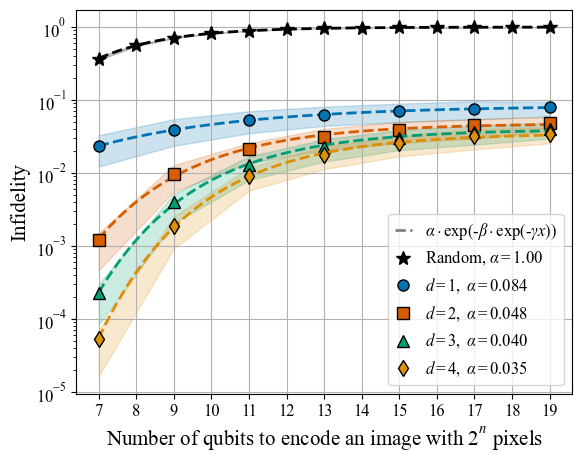

In [3]:
import os
import sys
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from stylesheet import *
sys.path.append(os.path.dirname(os.getcwd()))

def compute_infidelity(states1, states2):
    overlap = np.sum(np.conj(states1) * states2, axis=1)
    return 1 - np.abs(overlap) ** 2

paths = [
    "../results/old/imagenette2_res_info_orthogonal_4_20250114-010052",
    "../results/old/imagenette2_res_info_orthogonal_4_20250113-064231",
    "../results/old/imagenette2_res_info_orthogonal_4_20250113-064750",
    "../results/old/imagenette2_res_info_orthogonal_4_20250113-065235",
    "../results/old/imagenette2_res_info_orthogonal_4_20250113-065953",
    "../results/old/imagenette2_res_info_orthogonal_4_20250113-072739",
    "../data/imagenette/_orthogonal_8_20250308-091431"
]

all_results = {}

for path in paths:
    with open(f"{path}/config.yml", "r") as file:
        config = yaml.safe_load(file)
    shape = config.get("shape", str(path))
    if isinstance(shape, list):
        shape = tuple(shape)
    num_qubits = int(np.log2(np.prod(shape))) + 3
    try:
        compressed_full = np.load(f"{path}/compressed_full.npy", allow_pickle=True)
    except FileNotFoundError:
        compressed_full = np.load(f"{path}/compressed.npy", allow_pickle=True)
    frqi_target = np.stack(compressed_full["frqi_target"])
    depths = range(8)
    mean_infidelities = []
    percentiles_25 = []
    percentiles_75 = []
    for d in depths:
        key = f"state_{d}"
        if key in compressed_full.dtype.names:
            state_data = np.stack(compressed_full[key])
            infidelities = compute_infidelity(frqi_target, state_data)
            mean_infidelities.append(np.mean(infidelities))
            percentiles_25.append(np.percentile(infidelities, 25))
            percentiles_75.append(np.percentile(infidelities, 75))
        else:
            mean_infidelities.append(np.nan)
            percentiles_25.append(np.nan)
            percentiles_75.append(np.nan)
    all_results[num_qubits] = (mean_infidelities, percentiles_25, percentiles_75)

qubit_values = sorted(all_results.keys())
depths_to_plot = [0, 1, 2, 3]
colors = [
    color_palette["blue"],
    color_palette["red"],
    color_palette["green"],
    color_palette["orange"],
]
markers = [
    marker["circle"],
    marker["square"],
    marker["triangle"],
    marker["diamond"],
]

def gompertz(x, a, b, c):
    return np.log(a) - b * np.exp(-c * x)

plt.figure()
randoms = pd.read_csv("../data/randoms/_summary.csv")

randoms_infidelities = randoms["mean_infidelity"].values
randoms_percentiles_25 = randoms["25th_percentile"].values
randoms_percentiles_75 = randoms["75th_percentile"].values

randoms_qubits = randoms["qubits"].values
xdata_random = np.array(randoms_qubits, dtype=float)
ydata_random = np.array(randoms_infidelities, dtype=float)
initial_guess_random = [0.1, 0.1, 0.1]
popt_random, pcov_random = curve_fit(
    gompertz,
    xdata_random,
    np.log(ydata_random),
    p0=initial_guess_random,
    bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
    maxfev=20000
)
a_random, b_random, c_random = popt_random
std_a_random, std_b_random, std_c_random = np.sqrt(np.diag(pcov_random))
print(f"Random: a={a_random:.3f} ± {std_a_random:.3f}, b={b_random:.1f} ± {std_b_random:.1f}, c={c_random:.3f} ± {std_c_random:.3f}")
plt.plot([], [], '--', color="gray", linewidth=line_width, label=r'$\alpha \cdot \exp(\text{-}\beta \cdot \exp(\text{-}\gamma x))$')
plt.plot(
    randoms_qubits,
    randoms_infidelities,
    marker='*',
    color='black',
    linestyle='',
    markersize=marker_size+2,
    linewidth=line_width,
    markeredgewidth=markeredgewidth,
    # label=fr"Random, $\alpha={a_random:.3f},\ \beta={b_random:.1f},\ \gamma={c_random:.1f}$"
    label=fr"Random, $\alpha={a_random:.2f}$"
)
plt.fill_between(
    randoms_qubits,
    randoms_percentiles_25,
    randoms_percentiles_75,
    color="black",
    alpha=0.2
)
xfit_random = np.linspace(min(randoms_qubits), max(randoms_qubits), 300)
yfit_log_random = gompertz(xfit_random, *popt_random)
yfit_random = np.exp(yfit_log_random)
plt.plot(xfit_random, yfit_random, color='black', linestyle='--', linewidth=line_width, label="")

for i, d in enumerate(depths_to_plot):
    infidelities_for_depth = [all_results[q][0][d] for q in qubit_values]
    xdata = np.array(qubit_values, dtype=float)
    ydata = np.array(infidelities_for_depth, dtype=float)
    initial_guess = [0.1, 0.1, 0.1]
    popt, pcov = curve_fit(
        gompertz,
        xdata,
        np.log(ydata),
        p0=initial_guess,
        bounds=([0, 0, 0], [np.inf, np.inf, np.inf]),
        maxfev=40000
    )
    xfit = np.linspace(min(qubit_values), max(qubit_values), 300)
    yfit_log = gompertz(xfit, *popt)
    yfit = np.exp(yfit_log)
    plt.plot(
        xfit,
        yfit,
        color=colors[i],
        linestyle='--',
        linewidth=line_width
    )
    percentiles_25_for_depth = [all_results[q][1][d] for q in qubit_values]
    percentiles_75_for_depth = [all_results[q][2][d] for q in qubit_values]
    plt.fill_between(
        qubit_values,
        percentiles_25_for_depth,
        percentiles_75_for_depth,
        color=colors[i],
        alpha=0.2
    )
    a, b, c = popt
    std_a, std_b, std_c = np.sqrt(np.diag(pcov))
    print(f"d={d}: a={a:.3f} ± {std_a:.3f}, b={b:.3f} ± {std_b:.3f}, c={c:.3f} ± {std_c:.3f}")
    plt.plot(
        qubit_values,
        infidelities_for_depth,
        marker=markers[i],
        color=colors[i],
        markersize=marker_size,
        markeredgecolor='black',
        linestyle='',
        markeredgewidth=markeredgewidth,
        label=(
            fr"$d={d+1},\ \alpha={a:.3f}$"
            # fr"$\alpha={a:.3f},\ \beta={b:.1f},\ \gamma={c:.1f}$"
        )
    )

plt.xticks(randoms_qubits)
plt.xlabel('Number of qubits to encode an image with ' + r'$2^{\mathit{n}}$' + ' pixels')
plt.ylabel("Infidelity")
plt.grid(True)
plt.yscale('log')
plt.legend(loc='lower right', handlelength=1)
plt.subplots_adjust(bottom=0.12, top=0.92)
plt.savefig(f"encoding_dim_infid.pdf")
plt.show()
